In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_60 import VitalSignsDataset,vital_pre_train
from model.tdpsom.tdospm import *
from model.tdpsom.tdospm_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


# labels_train = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# labels_val = [int(dataset_val[i][-1]) for i in range(len(dataset_val))]
# labels_test = [int(dataset_test[i][-1]) for i in range(len(dataset_test))]

# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)
# val_sampler = ImbalancedDatasetSampler(dataset_val, labels=labels_val)
# test_sampler = ImbalancedDatasetSampler(dataset_test, labels=labels_test)

# ## build the dataloader
# train_loader = DataLoader( dataset_train,batch_size=32,sampler=train_sampler,collate_fn=vital_pre_train )
# val_loader = DataLoader( dataset_val,batch_size=32,sampler=val_sampler,collate_fn=vital_pre_train)
# test_loader = DataLoader( dataset_test,batch_size=32,sampler=test_sampler,collate_fn=vital_pre_train )


train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=16, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=16,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/tdpsom/resampled_60"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-4)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer_pred = torch.optim.Adam(model.predictor.parameters(), lr=1e-3)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=120, save_dir=stage1_dir, patience=50,kl_warmup_epochs=80)

[Epoch 0] KL weight: 0.0000, KL: 0.0000
[Epoch 1] KL weight: 0.0013, KL: 0.4472
[Epoch 2] KL weight: 0.0025, KL: 1.0020
[Epoch 3] KL weight: 0.0037, KL: 1.5884
[Epoch 4] KL weight: 0.0050, KL: 2.1609
[Epoch 5] KL weight: 0.0063, KL: 2.7030
[Epoch 6] KL weight: 0.0075, KL: 3.1515
[Epoch 7] KL weight: 0.0087, KL: 3.5301
[Epoch 8] KL weight: 0.0100, KL: 3.8370
[Epoch 9] KL weight: 0.0113, KL: 4.0108
[Epoch 10] KL weight: 0.0125, KL: 4.2001
[Epoch 11] KL weight: 0.0138, KL: 4.3045
[Epoch 12] KL weight: 0.0150, KL: 4.1568
[Epoch 13] KL weight: 0.0163, KL: 4.0522
[Epoch 14] KL weight: 0.0175, KL: 4.0598
[Epoch 15] KL weight: 0.0188, KL: 4.0091
[Epoch 16] KL weight: 0.0200, KL: 3.9555
[Epoch 17] KL weight: 0.0213, KL: 3.8786
[Epoch 18] KL weight: 0.0225, KL: 3.7824
[Epoch 19] KL weight: 0.0238, KL: 3.7966
[Epoch 20] KL weight: 0.0250, KL: 3.6990
[Epoch 21] KL weight: 0.0263, KL: 3.6376
[Epoch 22] KL weight: 0.0275, KL: 3.6464
[Epoch 23] KL weight: 0.0287, KL: 3.6278
[Epoch 24] KL weight: 0.03

In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage1/best_ae.pth'
# model1 = PatientAutoencoder(
#     n_features=154, embedding_dim=128,  n_heads=2, som_grid=(10,10)
# ).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

In [5]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

 Initialized SOM with 100 embeddings (4 classes with 25 samples)


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=100,save_dir=stage2_dir,patience=50)

[SOM] Phase 1 Epoch 10/100 Avg Loss: 0.2864
[SOM] Phase 1 Epoch 20/100 Avg Loss: 0.2804
[SOM] Phase 1 Epoch 30/100 Avg Loss: 0.2836
[SOM] Phase 2 Epoch 40/100 Avg Loss: 0.2768
[SOM] Phase 2 Epoch 50/100 Avg Loss: 0.2781
[SOM] Phase 2 Epoch 60/100 Avg Loss: 0.2763
[SOM] Phase 3 Epoch 70/100 Avg Loss: 0.2725
[SOM] Phase 3 Epoch 80/100 Avg Loss: 0.2726
[SOM] Phase 3 Epoch 90/100 Avg Loss: 0.2741


In [ ]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/tdpsom/stage2/best_joint.pth'
model2 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

In [7]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader, train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Ep30: Calculating global target P...


[Joint] Ep30 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Ep40: Calculating global target P...


[Joint] Ep40 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Early stopping at epoch 41 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


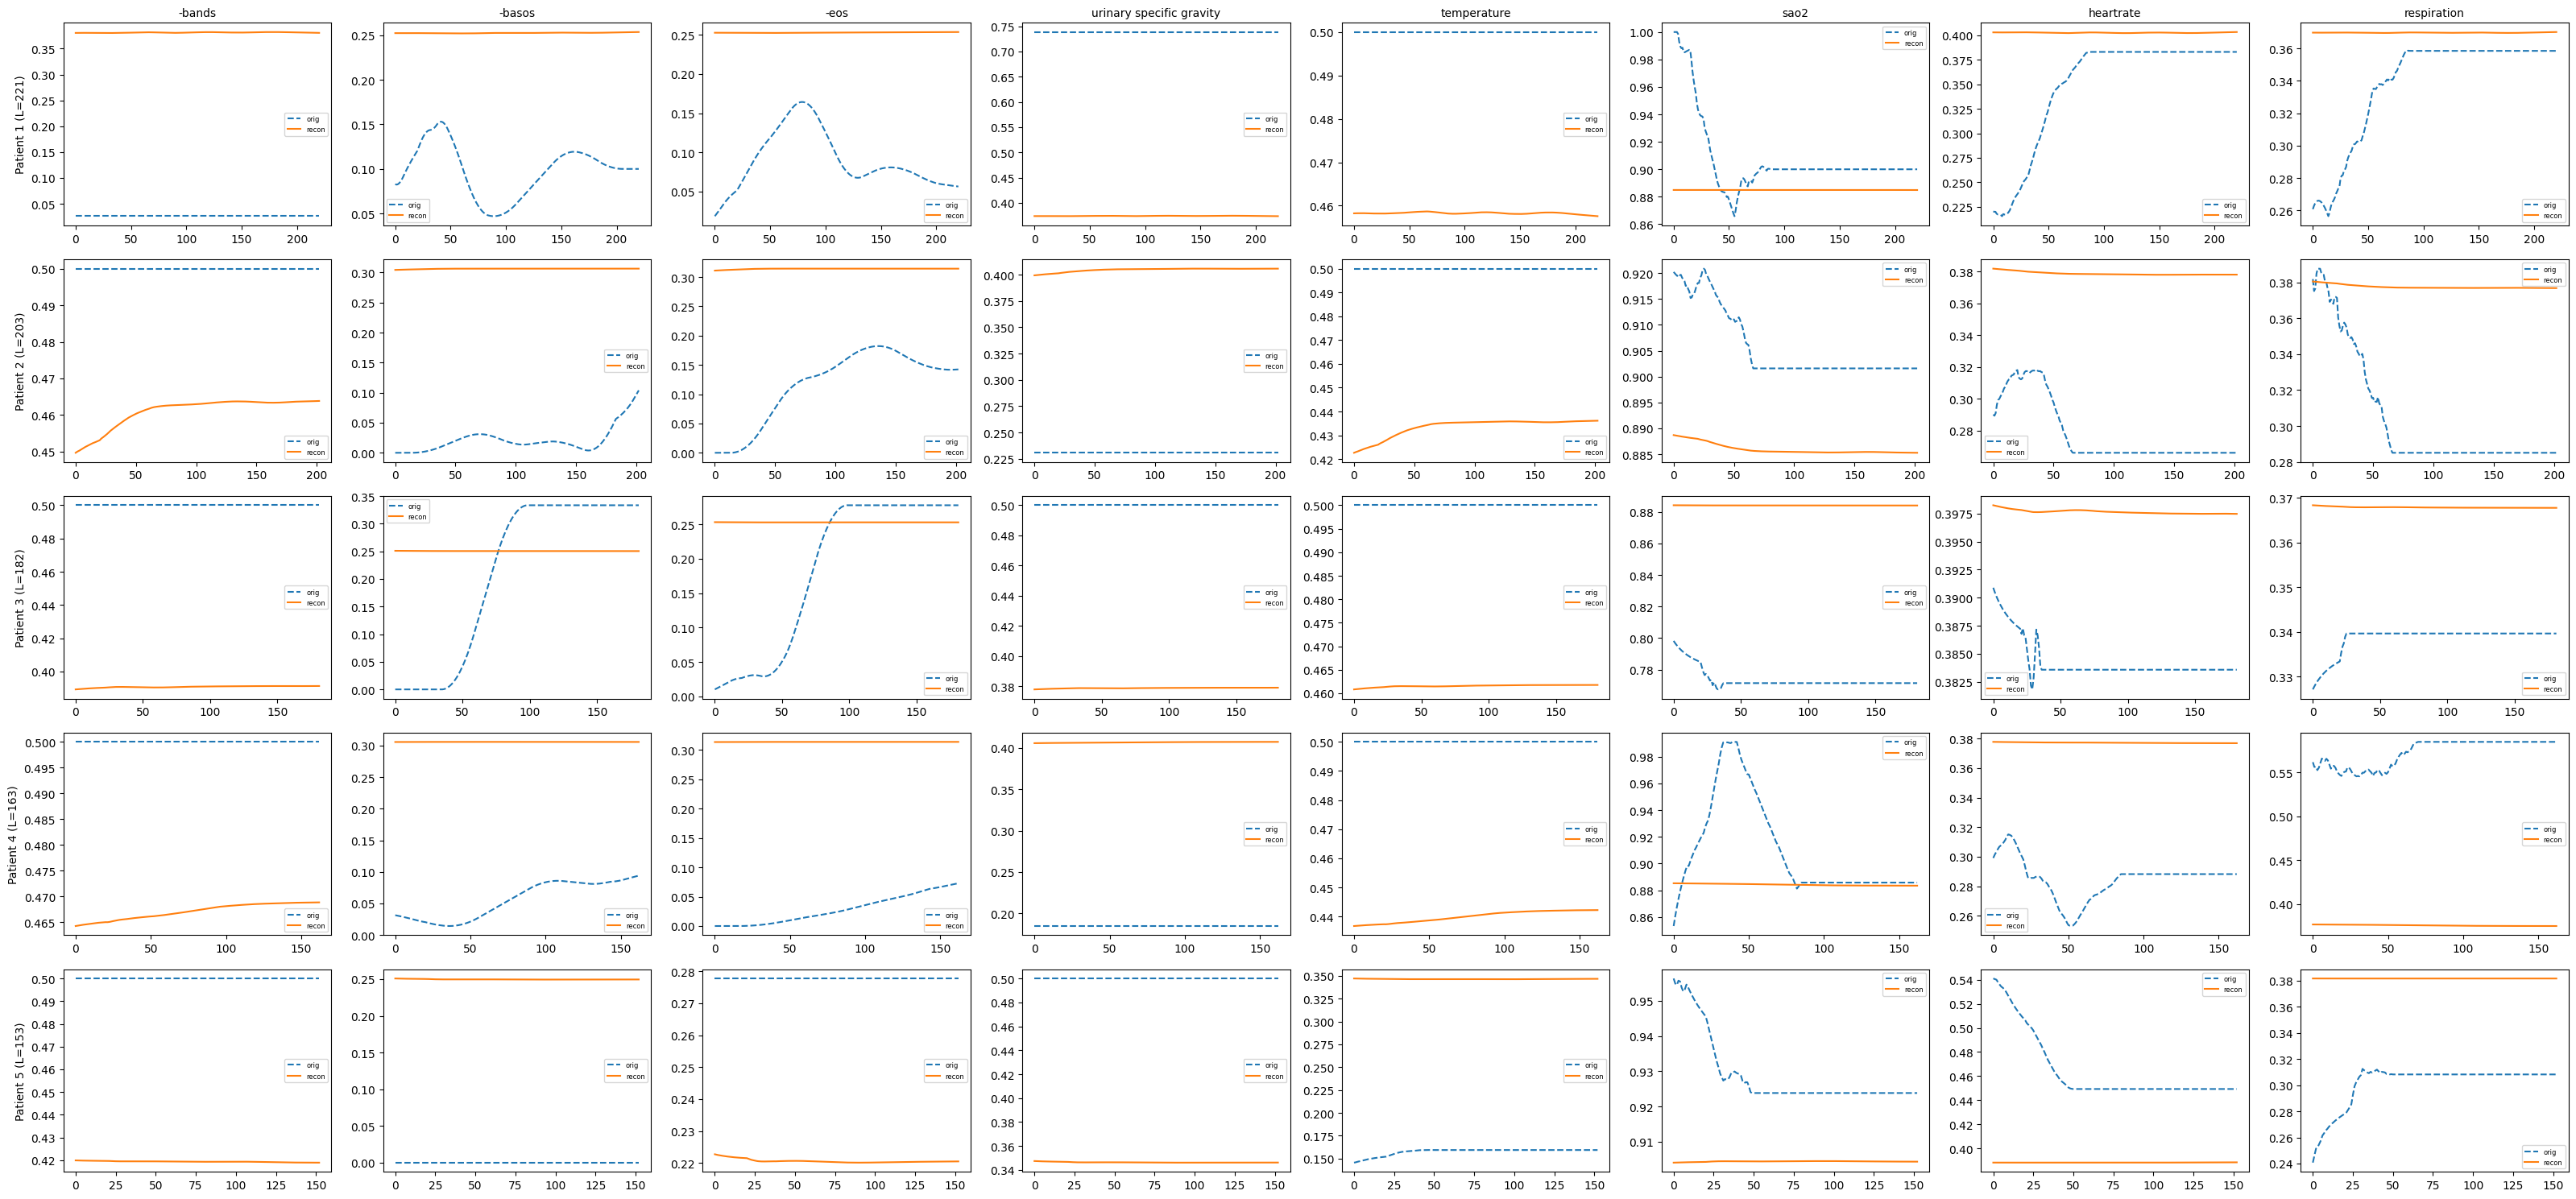

In [8]:
## 32
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]
selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)

Analyzing latent statistics for 20 batches...

--- Latent Space Statistics ---
Analyzed 39547 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean of mu (across all samples and dims): 0.0032
  Std of mu (across all samples and dims): 0.4683
  Mean of mu per latent dim (avg over samples):
tensor([ 0.5994, -0.3190,  0.4036, -0.1689,  0.0043,  0.3614,  0.2740,  0.1091,
         0.0251,  0.3251,  0.2572, -0.1942,  0.4737,  0.1165, -0.0041,  0.3004,
        -0.0898, -0.2499,  0.1673,  0.2176, -0.0321, -0.0882, -0.3098, -0.1934,
        -0.3868, -0.1674,  0.0439, -0.0605,  0.1247, -0.0975, -0.0845,  0.6625,
         0.3095,  0.1479, -0.0399, -0.0071, -0.1449,  0.1994,  0.0584, -0.2103,
        -0.2678, -0.1908, -0.2158,  0.1689,  0.1456, -0.2346, -0.2220, -0.0924,
         0.4667,  0.3651, -0.4320, -0.1806,  0.2357, -0.3746, -0.3702,  0.2700,
        -0.0196,  0.2643, -0.1792,  0.0974,  0.1566,  0.0018,  0.0456,  0.0679,
         0.1691,  0.3890,  0.0032, -0.0741, -0.1782, -0.0524, -0.1917, 

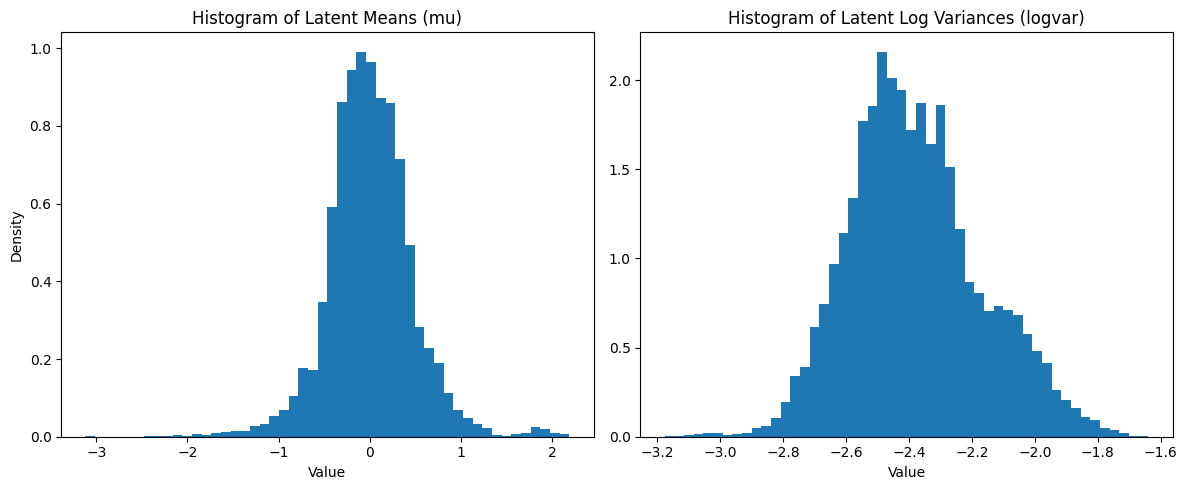

In [9]:
analyze_latent_stats(model3, test_loader, device, num_batches_to_analyze=20)

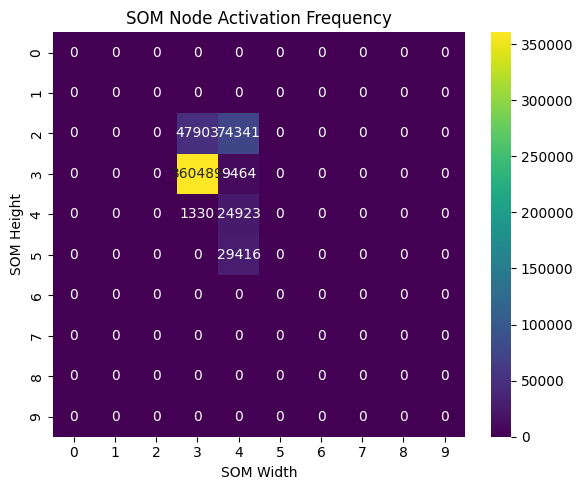

In [10]:
activation_map = compute_som_activation_heatmap(model3, train_loader, device)
plot_som_activation_heatmap(activation_map)

In [5]:
stage3 = '/home/mei/nas/docker/thesis/data/model_results/tdpsom/resampled_60/stage3/best_joint.pth'
model3 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

model3.load_state_dict(torch.load(stage3, map_location=device,weights_only=True))

<All keys matched successfully>

In [11]:
from sklearn.manifold import TSNE
import umap
def collect_latents(model, data_loader, device, max_batches=20):
    model.eval()
    zs, ys = [], []
    with torch.no_grad():
        for i, (x, lengths, _, labels) in enumerate(data_loader):
            if i >= max_batches:
                break
            x = x.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            out = model(x, lengths, is_training=False)
            # flat mu: (B*T_max, D_latent)
            mu_flat = out["z_dist_flat"].mean  
            B = x.size(0)
            # 恢复成 (B, T_max, D_latent)
            T_max = mu_flat.size(0) // B
            D_latent = mu_flat.size(1)
            mu_seq = mu_flat.view(B, T_max, D_latent)

            for b in range(B):
                valid_len = lengths[b].item()
                zs.append(mu_seq[b, :valid_len, :].cpu())        # (valid_len, D_latent)
                ys.append(labels[b].repeat(valid_len).cpu())     # (valid_len,)

    z_all = torch.cat(zs, dim=0).numpy()  # (N, D_latent)
    y_all = torch.cat(ys, dim=0).numpy()  # (N,)
    print(f"z_all shape: {z_all.shape}, y_all shape: {y_all.shape}")
    return z_all, y_all


def plot_tsne(z_all, y_all, perplexity=15):
    tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', random_state=42)
    z_2d = tsne.fit_transform(z_all)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=z_2d[:,0], y=z_2d[:,1], hue=y_all, palette="tab10", s=15, alpha=0.7)
    plt.title("t-SNE Visualization of Latent Space")
    plt.xlabel("z[0]"); plt.ylabel("z[1]")
    plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    


def plot_umap(z_all, y_all, n_neighbors=15, min_dist=0.1, metric='euclidean'):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42
    )
    z_2d = reducer.fit_transform(z_all)

    df = pd.DataFrame({
        "x": z_2d[:, 0],
        "y": z_2d[:, 1],
        "label": y_all
    })

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="x", y="y", hue="label", palette="tab10", s=15, alpha=0.7)
    plt.title("UMAP Visualization of Latent Space")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()    

z_all shape: (30437, 128), y_all shape: (30437,)


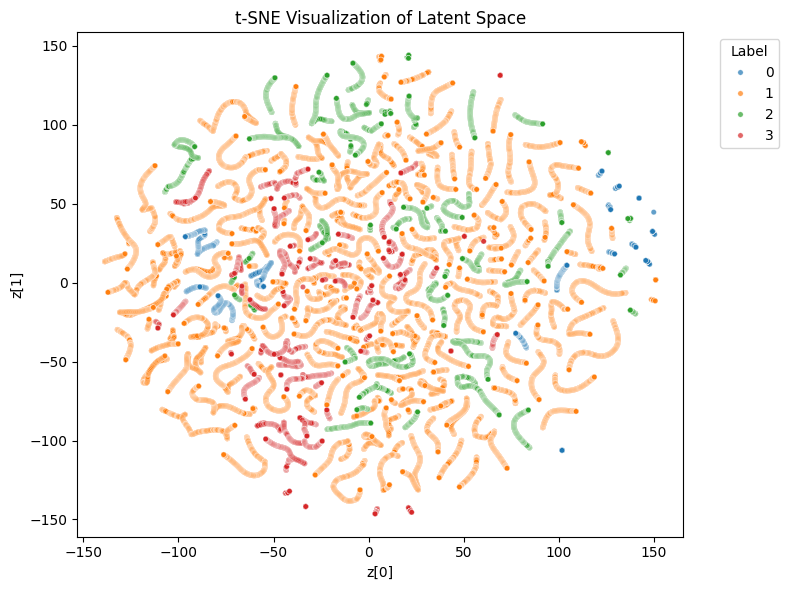

In [12]:
z_all, y_all = collect_latents(model3, data_loader= train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


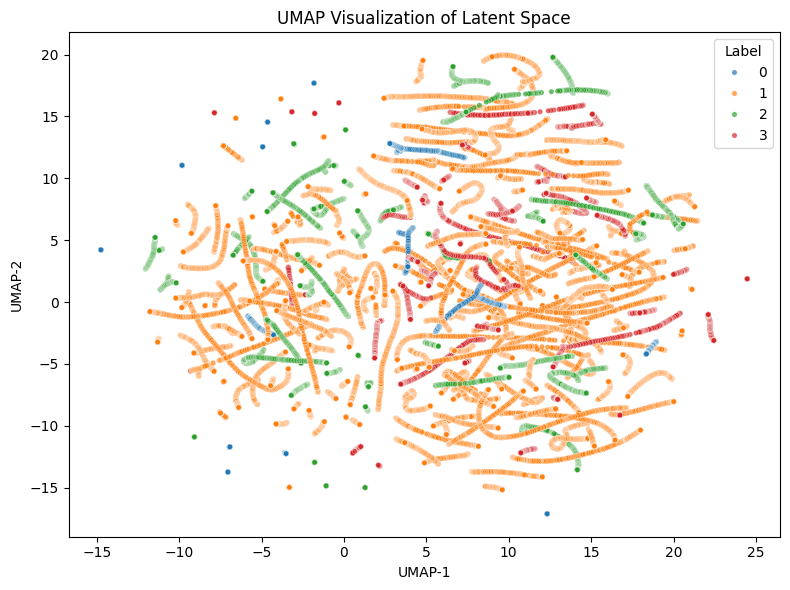

In [13]:
plot_umap(z_all, y_all)